<center><h1>Основы глубокого обучение</h1></center>

In [1]:
!python -V # Версия Python

Python 3.12.8


In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
import jupyterlab as jlab
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Yfinance", "Scikit-learn", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, np, pl, pd, mpl, yf, sklearn, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""NumPy""","""1.26.4"""
3,"""Polars""","""1.19.0"""
4,"""Pandas""","""2.2.3"""
5,"""Matplotlib""","""3.10.0"""
6,"""Yfinance""","""0.2.51"""
7,"""Scikit-learn""","""1.6.1"""
8,"""Ipywidgets""","""8.1.5"""
9,"""JupyterLab""","""4.3.4"""


# Лекция 5

4. **Современные архитектуры глубокого обучения**
    - Обзор семейства Mamba
    - Применение данных архитектур для анализа последовательных данных, изображений и мультимодальной интеграции

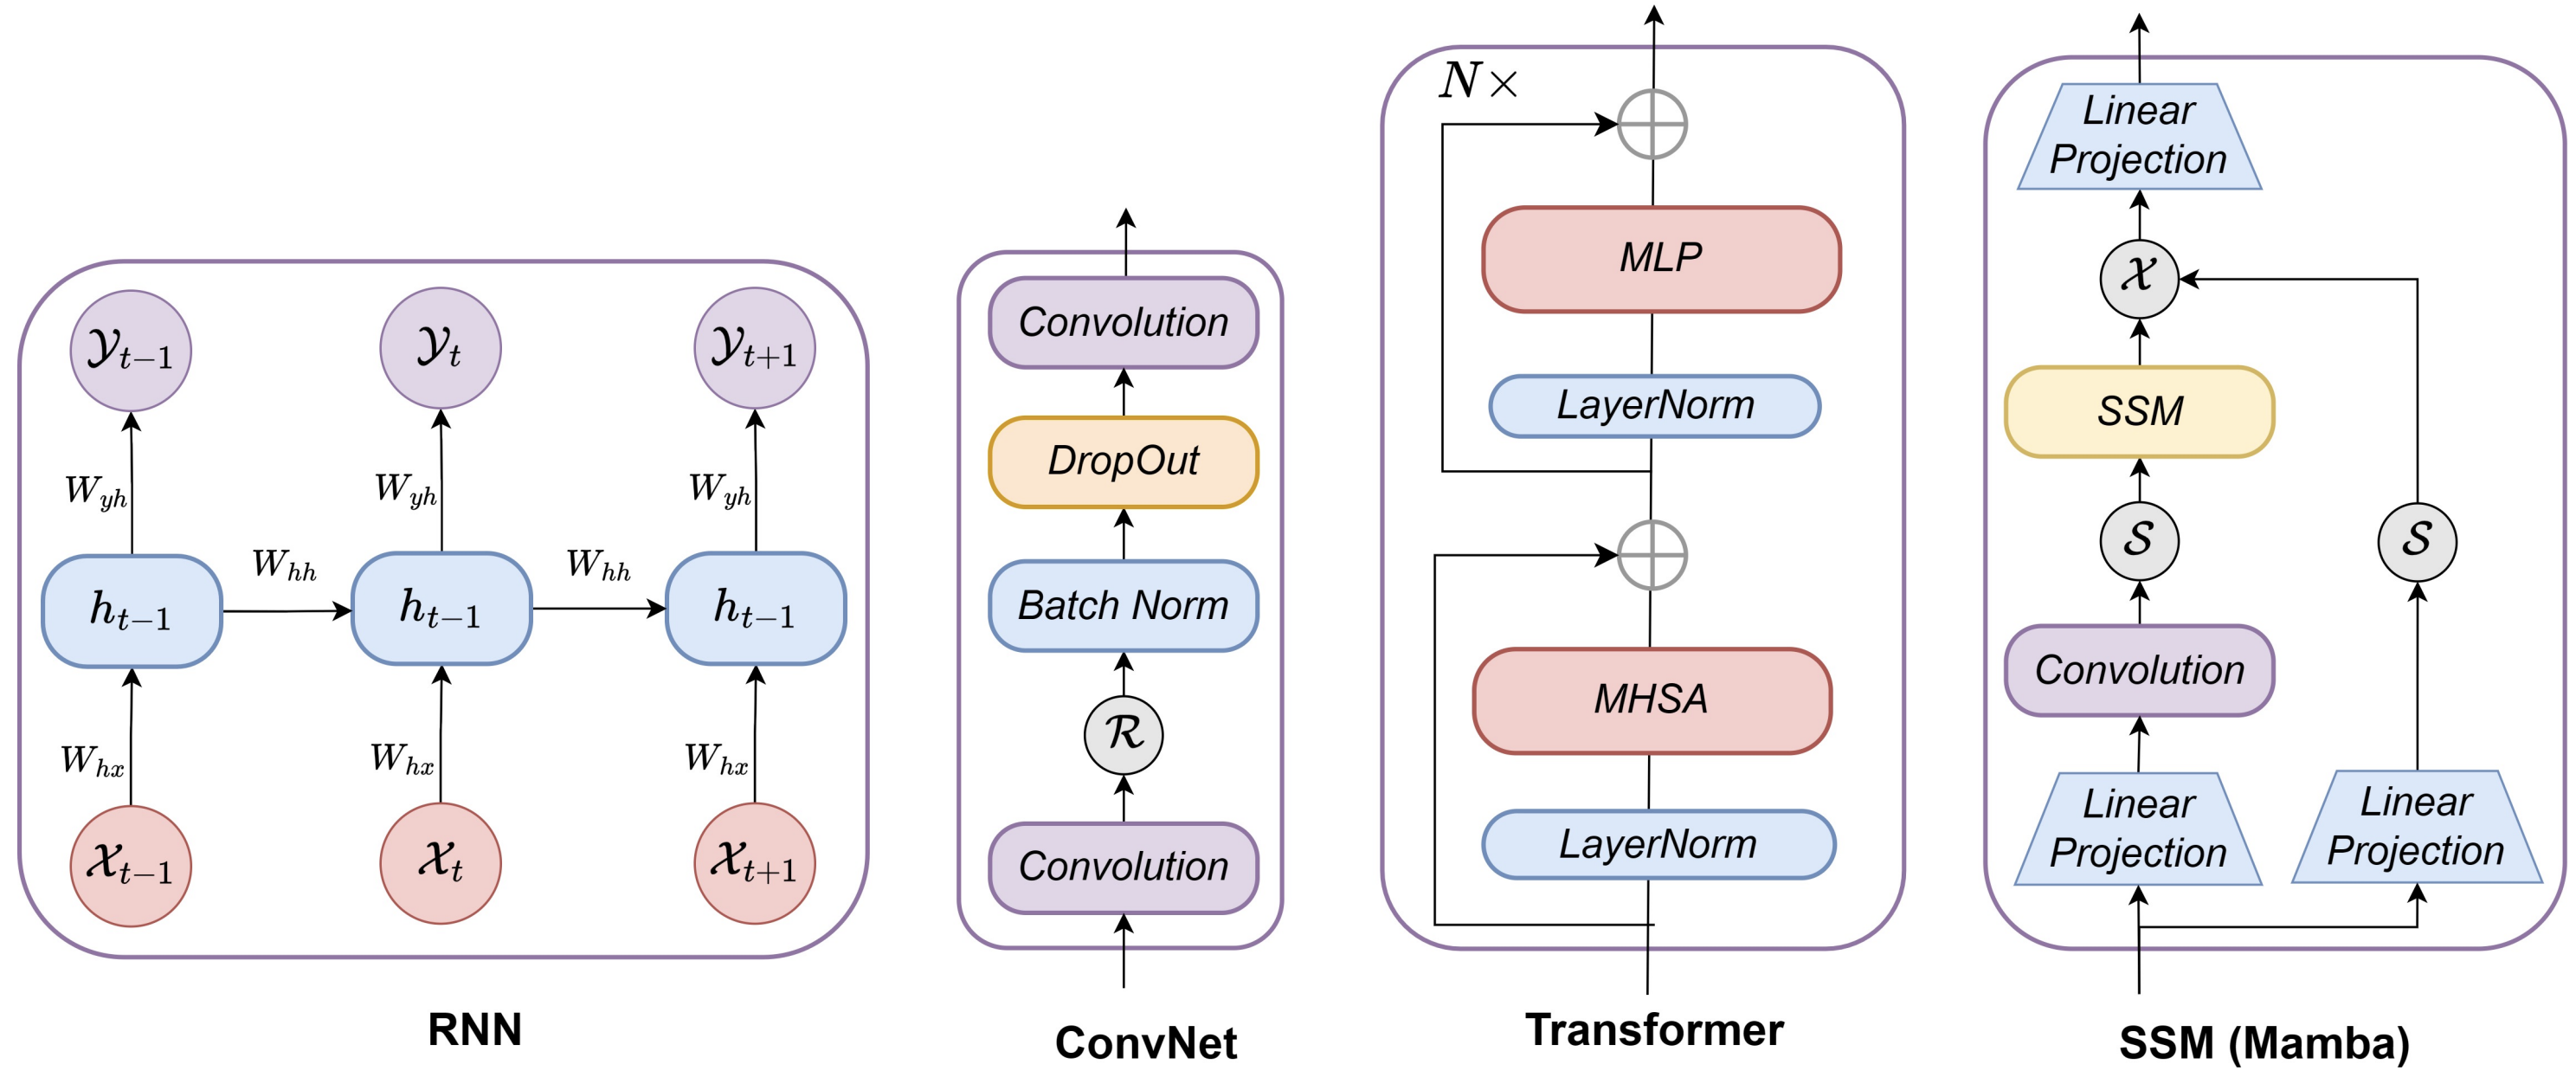

### Ограничения трансформеров

Трансформеры стали стандартом в глубоких нейросетях для обработки последовательных данных, таких как текст, аудио и видео. Несмотря на их успех в ряде задач, существует несколько существенных ограничений, которые мешают их эффективному применению в ряде случаев:

1. **Квадратичная сложность вычислений по длине последовательности** $O(L^2)$
    - Это означает, что для каждой пары элементов последовательности вычисляются зависимости. В случае длинных последовательностей, например, текстов, размерность входных данных может стать чрезвычайно большой, что приводит к высокой вычислительной нагрузке
2. **Ограниченный контекст**
    - Трансформеры часто ограничены максимальной длиной контекста, который они могут обрабатывать за один раз, что требует разделения длинных последовательностей на более короткие фрагменты
    - Также, для эффективного инференса часто требуется кеширование состояний предыдущих шагов, что увеличивает затраты памяти
3. **Высокие требования к аппаратным ресурсам**
    - Для обучения трансформеров требуется много ресурсов, включая большое количество вычислительных ядер и высокоскоростные графические процессоры (GPU). Это делает обучение трансформеров затратным и ограничивает их использование в задачах с ограниченными ресурсами

### Structured State Space Models (SSM)

SSM - это семейство нейросетевых моделей, использующих пространство состояний для моделирования зависимостей в последовательных данных. SSM могут быть более эффективными по сравнению с трансформерами в ряде задач, благодаря нескольким ключевым свойствам:

1. **Линейная сложность $O(L)$ по длине последовательности**
    - В отличие от трансформеров, где сложность растет квадратично с увеличением длины последовательности, модели SSM имеют линейную сложность, что позволяет работать с длинными последовательностями намного быстрее
2. **Гибкость**:
    - Модели SSM могут моделировать как временные, так и пространственные зависимости, что делает их подходящими для различных типов данных, включая текст, аудио и видео
3. **Хорошая обобщаемость**:
    - Модели SSM показывают высокую обобщаемость на различных модальностях, что позволяет использовать их не только для обработки текста, но и для анализа аудио и видео данных
  
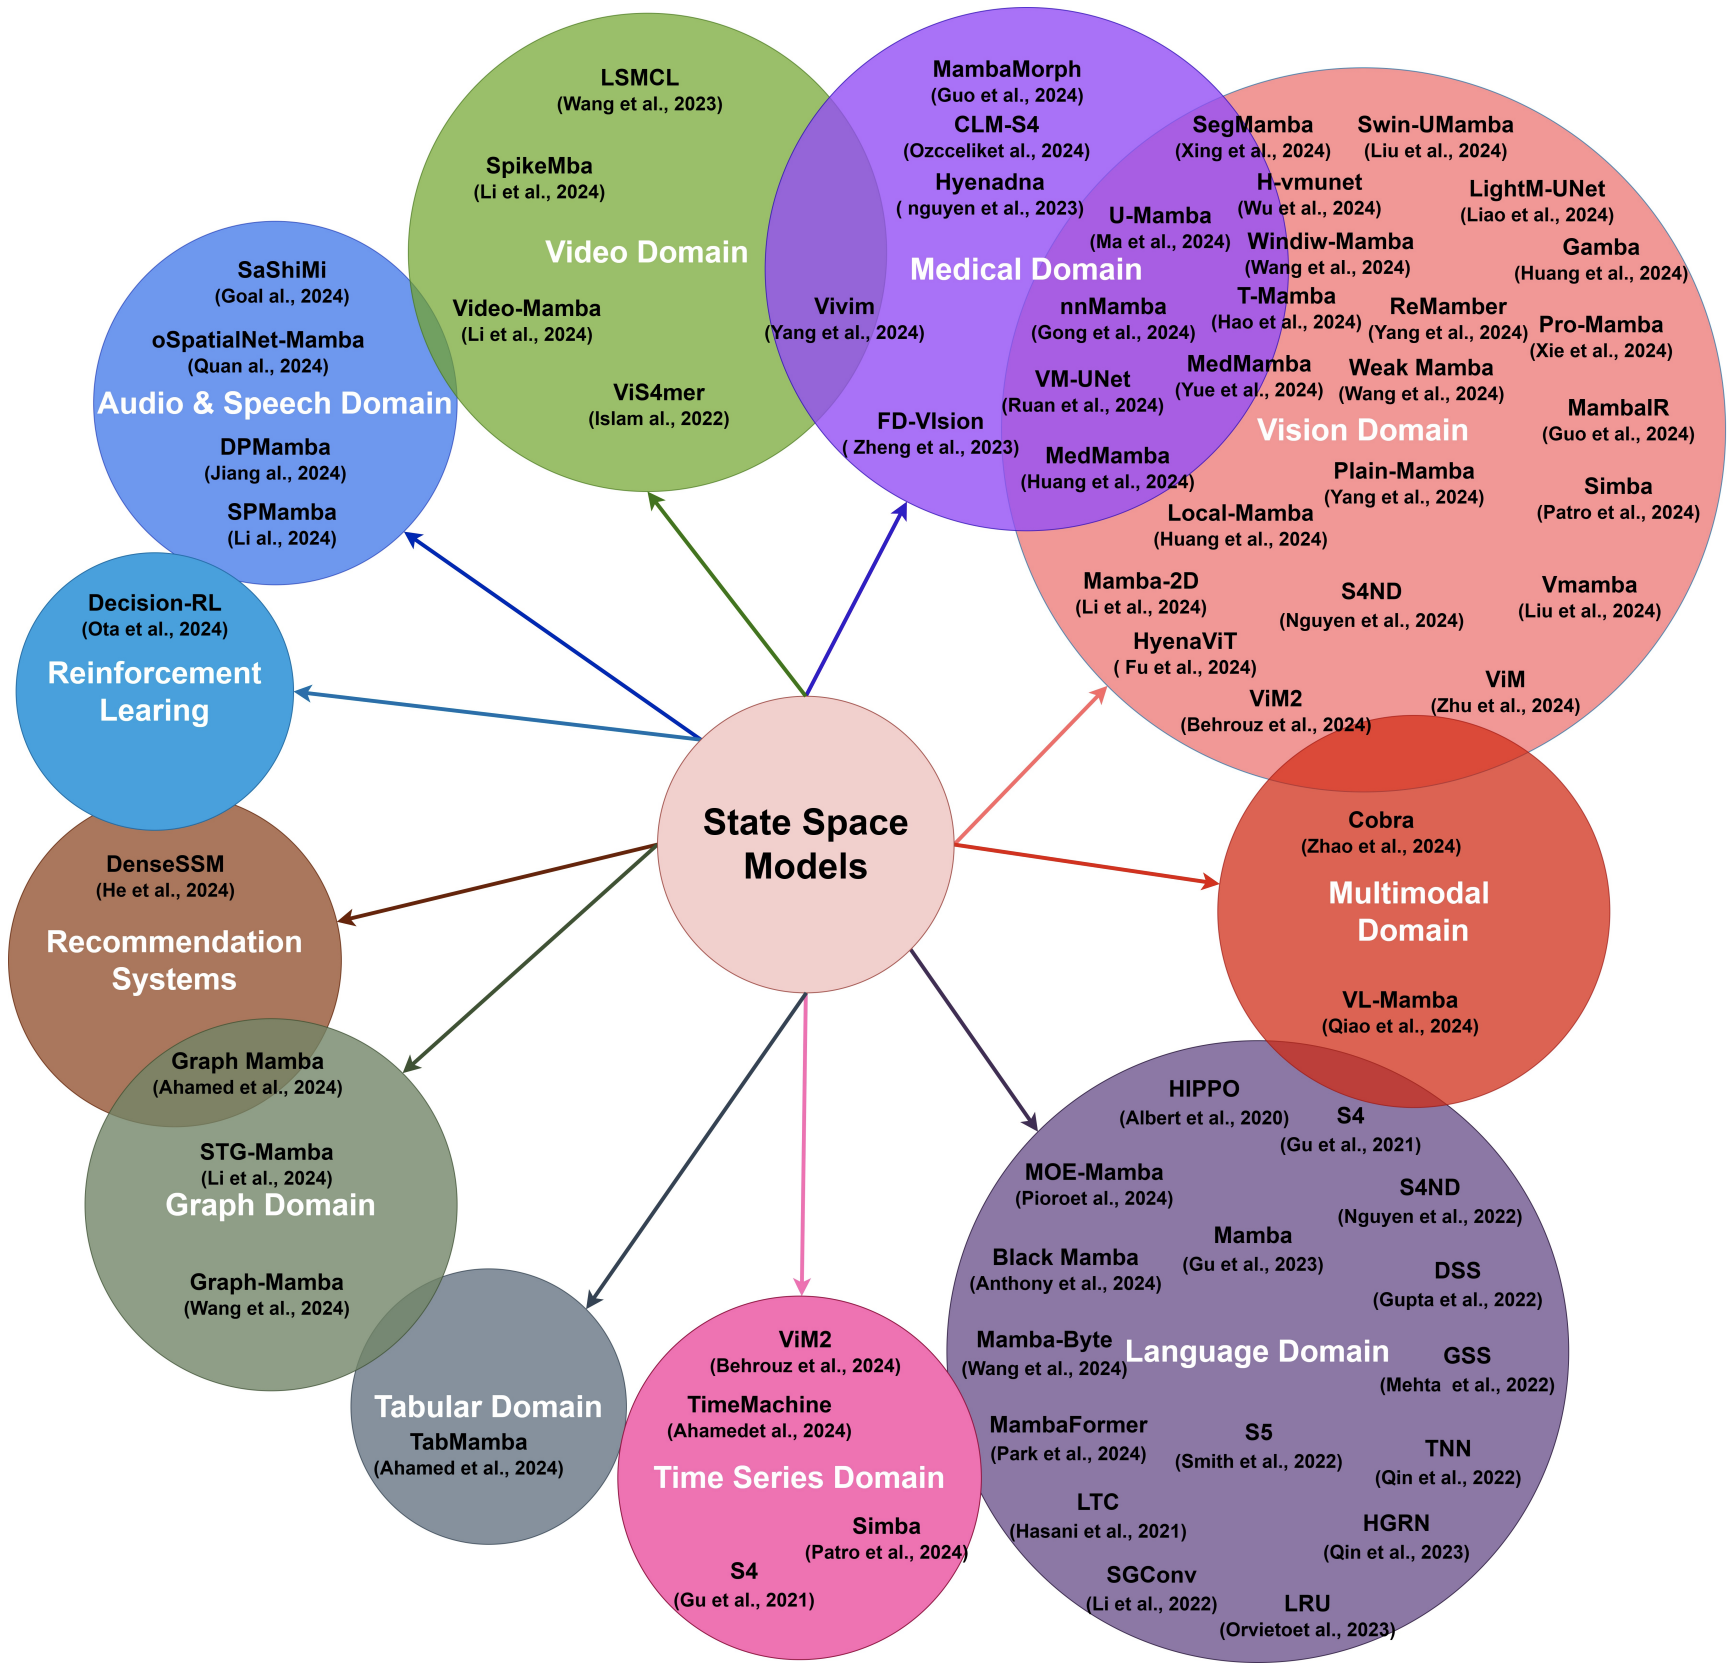

### Математическая основа SSM и Mamba

SSM представляют собой классические модели управления, которые могут быть описаны системой дифференциальных уравнений. На дискретном времени они представляют собой:

**Уравнение состояния SSM**

$$
h_t = A h_{t-1} + B x_t
$$

где:
- $h_t$ - скрытое состояние модели в момент времени $t$, которое содержит информацию о предыдущих входных данных и их изменениях
- $A$ - матрица перехода, которая описывает, как предыдущее состояние $h_{t-1}$ влияет на текущее состояние $h_t$
- $B$ - матрица входных данных, которая описывает, как входные данные $x_t$ влияют на скрытое состояние модели
- $x_t$ - входные данные на шаге $t$

**Уравнение выхода SSM**

$$
y_t = C h_t
$$

где:
- $y_t$ - выход модели в момент времени $t$, который получается путем применения матрицы $C$ к скрытому состоянию $h_t$. Это позволяет получить предсказания модели на основе скрытых представлений данных

**Дискретизация SSM**

В случае работы с дискретными данными, необходимо адаптировать SSM для дискретизации состояния. Это необходимо для корректной работы модели с последовательностями данных, где обновления состояния происходят на каждом шаге времени. Для дискретизации применяется следующий метод

$$
 A_d = e^{\Delta A}, \quad B_d = (A^{-1} (e^{\Delta A} - I)) B
$$

где:
- $\Delta$ - шаг дискретизации, который определяет, как часто обновляется скрытое состояние
- $e^{\Delta A}$ - экспоненциальная функция, которая позволяет получить дискретизированную матрицу перехода
- $I$ - единичная матрица, используемая для вычислений

Этот метод дискретизации позволяет сохранить важные свойства модели, такие как ее устойчивость и способность к долгосрочному запоминанию контекста, при этом не требуя сложных вычислений

### Механизм выбора (Selection Mechanism)

Одним из ключевых нововведений в Mamba является механизм выбора (Selection Mechanism), который заменяет self-attention и делает вычисления более эффективными. Этот механизм позволяет модели:

1. **Адаптивно запоминать или забывать информацию**
    - Модель может динамически регулировать, какие части последовательности должны быть запомнены, а какие - забыты в зависимости от значимости входных данных на текущем шаге
2. **Избежать необходимости в self-attention**
    - В отличие от трансформеров, где для обработки каждой пары элементов последовательности требуется вычисление внимания (self-attention), Mamba использует механизм выбора, который позволяет получать схожие результаты, но с линейной сложностью $O(L)$
3. **Обеспечить линейную сложность вычислений**
    - Несмотря на использование адаптивных параметров и динамическое обновление скрытых состояний, вычисления остаются линейными по сложности, что делает Mamba эффективным решением для работы с длинными последовательностями данных

### Преимущества механизма выбора

- **Адаптивность** позволяет модели динамически переключаться между долгосрочным запоминанием и забыванием
- **Эффективность** за счет линейной сложности $O(L)$ по длине последовательности, что значительно сокращает вычислительные затраты
- **Отказ от self-attention** снижает вычислительные расходы за счёт замены сложных операций внимания на более простые рекуррентные вычисления

### Формализованная интерпретация механизма выбора в Mamba

Механизм выбора в Mamba можно интерпретировать как обобщение механизма затворов в RNN. В RNN, механизм затворов управляет процессом обновления скрытых состояний. Например:

$$
g_t = \sigma(W x_t + U h_{t-1})
$$

$$
h_t = g_t \cdot h_{t-1} + (1 - g_t) \cdot x_t
$$

где:
- $g_t$ - это затвор, который регулирует, сколько информации из предыдущего состояния $h_{t-1}$ будет сохранено, а сколько - заменено новым входом $x_t$
- $\sigma$ - это сигмоида, которая ограничивает значения $g_t$ в интервале от 0 до 1

В механизме выбора Mamba, аналогичные принципы используются для адаптивного контроля обновлений состояния, но с более гибкими параметрами, зависящими от входных данных

### Как Mamba реализует механизм выбора эффективно с точки зрения вычислений?

Механизм выбора в Mamba - это ключевая особенность, которая позволяет моделям работать с длинными последовательностями данных, избегая необходимости в затратном self-attention, сохраняя линейную сложность вычислений по длине последовательности ($O(L)$)

#### Параметризация механизма выбора

Механизм выбора в Mamba использует параметризацию, которая позволяет динамически адаптировать процессы запоминания и забывания в зависимости от входных данных на каждом шаге. Это может быть сделано через:

- **Затворы (gates)**: аналогично RNN, где используются функции активации (например, сигмоида) для вычисления веса, с которым предыдущее состояние будет смешано с новым входом. Вместо того, чтобы работать с фиксированным набором параметров, Mamba использует динамическое вычисление этих весов в зависимости от текущего контекста
- **Адаптивные веса**: весовое значение для каждого шага вычисляется адаптивно, что позволяет модели больше или меньше запоминать информации в зависимости от её значимости.

#### Линейная сложность $O(L)$

При использовании рекуррентных вычислений обновление состояния происходит за один шаг для каждого элемента последовательности. На каждый шаг $t$ необходимо лишь вычислить скрытое состояние $h_t$ на основе предыдущего состояния $h_{t-1}$ и текущего входа $x_t$. Эти вычисления происходят за $O(1)$ для каждого шага, что дает общую сложность $O(L)$ по длине последовательности

Это отличие от квадратичной сложности в трансформерах делает Mamba гораздо более эффективным для работы с длинными последовательностями

#### Обработка длинных последовательностей

Механизм выбора позволяет динамически выбирать, какая информация важна для долгосрочного запоминания, а какая может быть забыта. Это достигается путем адаптивной модификации состояния в зависимости от входных данных. В отличие от трансформеров, где для каждого шага обновляется внимание на все элементы, Mamba обновляет только релевантные состояния, минимизируя вычислительные затраты

- **Долгосрочное запоминание**: на основе адаптивного механизма модель решает, что важно запомнить на длинных отрезках, обеспечивая качественное извлечение информации, даже из длинных контекстов
- **Забывание ненужных данных**: если какие-то данные или контексты оказываются несущественными для текущей задачи, механизм выбора позволяет их игнорировать, что снижает избыточность вычислений

#### Параллелизация на GPU

Использование рекуррентных вычислений с линейной сложностью значительно облегчает параллелизацию вычислений на GPU. В отличие от трансформеров, где для каждого шага нужно обрабатывать все токены с помощью attention, в Mamba можно параллельно обрабатывать несколько элементов последовательности, что ускоряет обучение и инференс

- **Параллелизация состояний**: поскольку каждый шаг $t$ вычисляется независимо от других с помощью рекуррентных вычислений, то можно параллельно обновлять несколько слоёв или несколько последовательностей, используя мощность современных графических процессоров
  
- **Меньше памяти**: также важным аспектом является то, что для работы с рекуррентными вычислениями требуется меньше памяти, чем для self-attention. Это позволяет использовать модели на более дешёвых GPU или ускоряет работу на существующих платформах

#### Гибкость и адаптивность

Механизм выбора может быть дополнительно адаптирован для разных типов данных (например, текст, аудио, видео). Это означает, что модель может динамически регулировать, какие части последовательности являются наиболее важными, и на каких этапах требуется запоминание или забывание, что делает её более гибкой для различных задач

Для работы с текстами модель может использовать одни параметры выбора, для аудио - другие, что позволяет моделям Mamba быть адаптированными к различным типам последовательных данных

### Gated Delta Networks: Улучшение Mamba2 с помощью Delta Rule

**Линейные трансформеры** (Mamba2) уменьшают вычислительные затраты, но сталкиваются с проблемами хранения информации. **Gated Delta Networks (Gated DeltaNet)** - новый метод, сочетающий преимущества **Mamba2** и **DeltaNet** для эффективного управления памятью

#### Различие между Mamba и Mamba2

Mamba2 является улучшенной версией оригинальной Mamba c модификациями

| Свойство | Mamba  | Mamba2 |
|----------|--------|--------|
| Основа | SSM | Улучшенный SSM с динамическим управлением памятью |
| Способ обновления состояния | Линейное обновление с фиксированными параметрами | Динамическое обновление с адаптивными весами |
| Гибкость обработки информации | Менее адаптивный | Более гибкий за счет использования **взвешенного затухания** |
| Эффективность вычислений | Оптимизированный линейный SSM | Оптимизированное рекуррентное обновление с уменьшенной потерей информации |

#### Обновление состояния в Mamba2

В Mamba2 динамика скрытого состояния происходит через

$$
h_t = A_t h_{t-1} + B_t x_t
$$

где:
- $A_t$ - адаптивная матрица перехода, изменяемая в зависимости от входных данных
- $B_t$ - матрица преобразования входных данных
- $x_t$ - входной вектор на шаге $t$

Для адаптивного управления состоянием необходимо использовать **обучаемые функции**

$$
A_t = \sigma(W_A x_t), \quad B_t = \sigma(W_B x_t)
$$

где $W_A$ и $W_B$ - параметризованные матрицы, а $\sigma$ - активационная функция (например, сигмоида или ReLU)

#### Проблема памяти в линейных трансформерах

Линейные трансформеры заменяют механизм self-attention на линейные рекуррентные обновления состояния

$$
S_t = S_{t-1} + v_t k_t^T.
$$

Но этот подход имеет ограничения

- Количество ортогональных пар ключ-значение ограничено размерностью модели (**коллизия памяти**)
- Невозможно выборочно забывать устаревшую информацию (**ограниченная селективность обновлений**)

#### Математическая основа Gated Delta Rule

Gated DeltaNet использует новый рекуррентный механизм обновления памяти

$$
S_t = \alpha_t S_{t-1} (I - \beta_t k_t k_t^T) + \beta_t v_t k_t^T,
$$

где
- $\alpha_t$ - коэффициент затухания, определяющий степень сохранения предыдущей памяти
  $$
  \alpha_t = \sigma(W_\alpha x_t + b_\alpha)
  $$
- $\beta_t$ - параметр, управляющий заменой старых значений
  $$
  \beta_t = \sigma(W_\beta x_t + b_\beta)
  $$
- $I - \beta_t k_t k_t^T$ - матрица фильтрации устаревших значений, предотвращающая переполнение памяти

Дополнительно используется механизм **нормализации состояния**

$$
S_t \leftarrow \frac{S_t}{\| S_t \| + \epsilon}
$$

что предотвращает взрывные градиенты и улучшает стабильность обучения

#### Аппаратная оптимизация: Chunkwise Parallel Form

Для эффективного обучения на GPU используется **chunkwise parallel form**

$$
S_{t+1} = \gamma_C S_t + (U_t - W_t S_t^T)^T D K_t
$$

где $\gamma_C$ - коэффициент затухания внутри chunkwise. Это направлено на:
- **Сохранение линейной сложности** по длине последовательности $O(L)$
- **Эффективное использование тензорных ядер** на GPU

# Семинар 5

In [30]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps - 1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan: Callable[[Tensor, Tensor], Tensor] = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8) -> None:
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: Tensor) -> Tensor:        
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim = True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        return self.out_proj(x + B + C)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super(Mamba, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])

    def forward(self, seq):
        for mamba in self.layers:
            seq = mamba(seq)
        return seq

model = Mamba(num_layers = 6, d_input = 512, d_model = 256)

input_tensor = torch.randn(32, 128, 512)
output = model(input_tensor)

print("Output shape:", output.shape)

target = torch.randn(32, 128, 512)
criterion = nn.MSELoss()
loss = criterion(output, target)
loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradients calculated for {name}")
    else:
        print(f"No gradients for {name}")

Output shape: torch.Size([32, 128, 512])
Gradients calculated for layers.0.in_proj.weight
Gradients calculated for layers.0.in_proj.bias
Gradients calculated for layers.0.s_B.weight
Gradients calculated for layers.0.s_B.bias
Gradients calculated for layers.0.s_C.weight
Gradients calculated for layers.0.s_C.bias
Gradients calculated for layers.0.out_proj.weight
Gradients calculated for layers.0.out_proj.bias
Gradients calculated for layers.1.in_proj.weight
Gradients calculated for layers.1.in_proj.bias
Gradients calculated for layers.1.s_B.weight
Gradients calculated for layers.1.s_B.bias
Gradients calculated for layers.1.s_C.weight
Gradients calculated for layers.1.s_C.bias
Gradients calculated for layers.1.out_proj.weight
Gradients calculated for layers.1.out_proj.bias
Gradients calculated for layers.2.in_proj.weight
Gradients calculated for layers.2.in_proj.bias
Gradients calculated for layers.2.s_B.weight
Gradients calculated for layers.2.s_B.bias
Gradients calculated for layers.2.s

In [31]:
model = Mamba(num_layers = 6, d_input = 512, d_model = 256)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

input_tensor = torch.randn(32, 128, 512)
target_tensor = torch.randn(32, 128, 512)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    
    # Прямой проход
    output = model(input_tensor)
    
    # Вычисление потерь
    loss = criterion(output, target_tensor)
    
    # Обратный проход
    loss.backward()
    
    # Обновление параметров модели
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Пример использования обученной модели
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    print("Output after training:", output.shape)

Epoch 1/100, Loss: 1.0016543865203857
Epoch 2/100, Loss: 1.0013811588287354
Epoch 3/100, Loss: 0.9985916614532471
Epoch 4/100, Loss: 0.9974302649497986
Epoch 5/100, Loss: 0.9964042901992798
Epoch 6/100, Loss: 0.9952939748764038
Epoch 7/100, Loss: 0.9941698312759399
Epoch 8/100, Loss: 0.9929973483085632
Epoch 9/100, Loss: 0.9918174743652344
Epoch 10/100, Loss: 0.9906189441680908
Epoch 11/100, Loss: 0.9894289374351501
Epoch 12/100, Loss: 0.9882356524467468
Epoch 13/100, Loss: 0.9870733618736267
Epoch 14/100, Loss: 0.985882043838501
Epoch 15/100, Loss: 0.9847323298454285
Epoch 16/100, Loss: 0.9835975766181946
Epoch 17/100, Loss: 0.9824730753898621
Epoch 18/100, Loss: 0.981449544429779
Epoch 19/100, Loss: 0.9804151058197021
Epoch 20/100, Loss: 0.9792637228965759
Epoch 21/100, Loss: 0.9782636165618896
Epoch 22/100, Loss: 0.9771883487701416
Epoch 23/100, Loss: 0.9762433767318726
Epoch 24/100, Loss: 0.9752490520477295
Epoch 25/100, Loss: 0.9743140935897827
Epoch 26/100, Loss: 0.97341763973236

## Домашнее задание: Обучение и визуализация Mamba

### Цель задания

1. Обучить простую модель семейства Mamba для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
2. Визуализировать веса внимания и интерпретировать их
3. Сделать выводы о том, как модель воспринимает данные и принимает решения